<a href="https://colab.research.google.com/github/Vaycold/Python_DL/blob/main/Text_Classification/naver_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal
   - Seq2Seq model
   - word embedding
   - time series data

## Import the Library & Load the data

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')


In [1]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2021-05-26 15:35:29--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  36.4MB/s    in 0.4s    

2021-05-26 15:35:30 (36.4 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]

--2021-05-26 15:35:30--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Savin

In [6]:
!ls -alh

total 19M
drwxr-xr-x 1 root root 4.0K May 26 15:35 .
drwxr-xr-x 1 root root 4.0K May 26 15:31 ..
drwxr-xr-x 4 root root 4.0K May  6 13:43 .config
-rw-r--r-- 1 root root 4.7M May 26 15:35 ratings_test.txt
-rw-r--r-- 1 root root  14M May 26 15:35 ratings_train.txt
drwxr-xr-x 1 root root 4.0K May  6 13:44 sample_data


In [7]:
train_df = pd.read_csv('ratings_train.txt', sep='\t')
test_df = pd.read_csv('ratings_test.txt', sep='\t')
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [8]:
test_df.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [19]:
train_df.columns

Index(['id', 'document', 'label'], dtype='object')

In [10]:
train_df.shape, test_df.shape

((150000, 3), (50000, 3))

In [11]:
print(train_df.dtypes)

id           int64
document    object
label        int64
dtype: object


In [12]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 6.5MB/s 
     |████████████████████████████████| 460kB 35.6MB/s 
     |████████████████████████████████| 92kB 8.3MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [13]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 6.7MB/s 


## Preprocessing

In [15]:
from konlpy.tag import Okt
okt = Okt()

In [16]:
okt.pos('오늘은 즐겁게 딥러닝 공부를 하고 있습니다')

[('오늘', 'Noun'),
 ('은', 'Josa'),
 ('즐겁게', 'Adjective'),
 ('딥', 'Noun'),
 ('러닝', 'Noun'),
 ('공부', 'Noun'),
 ('를', 'Josa'),
 ('하고', 'Verb'),
 ('있습니다', 'Adjective')]

In [17]:
list(filter(lambda x : x[1] == 'Noun', okt.pos('오늘은 즐겁게 딥러닝 공부를 하고 있습니다')))

[('오늘', 'Noun'), ('딥', 'Noun'), ('러닝', 'Noun'), ('공부', 'Noun')]

In [18]:
import sentencepiece as spm

In [28]:
train_df['document'].values.shape, test_df['document'].values.shape

((150000,), (50000,))

In [32]:
full_document = np.concatenate(
    [train_df['document'].values, test_df['document'].values])

with open('./full_document.txt', 'w', encoding='utf-8') as f:
    for line in full_document :
        if len(str(line).strip()) == 0 : continue
        try :
            f.write(line + '\n')
        except : continue


In [33]:
!ls -alh

total 36M
drwxr-xr-x 1 root root 4.0K May 26 17:21 .
drwxr-xr-x 1 root root 4.0K May 26 15:31 ..
drwxr-xr-x 4 root root 4.0K May  6 13:43 .config
-rw-r--r-- 1 root root  17M May 26 17:21 full_document.txt
-rw-r--r-- 1 root root 4.7M May 26 15:35 ratings_test.txt
-rw-r--r-- 1 root root  14M May 26 15:35 ratings_train.txt
drwxr-xr-x 1 root root 4.0K May  6 13:44 sample_data


In [35]:
!cat full_document.txt | head -n10

아 더빙.. 진짜 짜증나네요 목소리
흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
너무재밓었다그래서보는것을추천한다
교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.
원작의 긴장감을 제대로 살려내지못했다.
별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네
액션이 없는데도 재미 있는 몇안되는 영화
왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?


In [37]:
spm.SentencePieceTrainer.train('--input=full_document.txt --model_prefix=m --vocab_size=20000')

In [38]:
sp = spm.SentencePieceProcessor()
sp.load('m.model')

True

In [40]:
s = '오늘은 즐겁게 딥러닝 공부를 하고 있습니다.'

In [39]:
sp.encode_as_pieces('오늘은 즐겁게 딥러닝 공부를 하고 있습니다.')

['▁오늘', '은', '▁즐겁게', '▁', '딥', '러', '닝', '▁공부', '를', '▁하고', '▁있습니다', '.']

In [42]:
# 텍스트 id로 인코딩
sp.encode_as_ids(s)

[605, 17, 2634, 4, 19433, 320, 3864, 2747, 23, 306, 2100, 3]

In [43]:
# 텍스트 id로 디코딩
sp.decode_pieces(['▁오늘', '은', '▁즐겁게', '▁', '딥', '러', '닝', '▁공부', '를', '▁하고', '▁있습니다', '.'])

'오늘은 즐겁게 딥러닝 공부를 하고 있습니다.'

In [45]:
sp.decode_ids([605, 17, 2634, 4, 19433, 320, 3864, 2747, 23, 306, 2100, 3])

'오늘은 즐겁게 딥러닝 공부를 하고 있습니다.'

In [46]:
train_df['document']

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 150000, dtype: object

In [47]:
train_df['bow'] = train_df['document'].apply(lambda x : sp.encode_as_ids(str(x)))

In [48]:
test_df['bow'] = test_df['document'].apply(lambda x : sp.encode_as_ids(str(x)))

In [49]:
train_df.head()

,id,document,label,bow
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,"[55, 992, 5, 26, 15918, 1228]"
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,"[1494, 6, 4134, 162, 1679, 34, 368, 50, 15251,..."
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[18, 493, 19794, 543, 3006, 13489, 14, 2172, 292]"
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[14221, 200, 6985, 4, 5, 3718, 949, 90, 5, 690..."
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[3044, 5637, 1831, 235, 9, 18574, 2081, 330, 1..."


In [50]:
train_text = train_df['bow'].values
test_text  = test_df['bow'].values

In [54]:
train_text[:2]

array([list([55, 992, 5, 26, 15918, 1228]),
       list([1494, 6, 4134, 162, 1679, 34, 368, 50, 15251, 416, 1336, 8263, 876, 441])],
      dtype=object)

In [56]:
train_sentiment = train_df['label'].values
test_sentiment = test_df['label'].values

In [62]:
test_text.shape , len(test_sentiment)

((50000,), 50000)

In [63]:
# 모든 정수를 확인해보자
all_words = set([id for ids in train_text for id in ids]) | set([id for ids in test_text for id in ids])

In [64]:
sorted(all_words)[:5]

[0, 3, 4, 5, 6]

In [65]:
# train text와 test text를 bow형태로 변경
train_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_text)
test_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_text)

In [66]:
train_bow_text.shape, test_bow_text.shape

((150000, 132), (50000, 107))

In [67]:
# word count
import collections
word_count = collections.Counter()

for text in train_text : 
    word_count.update(text)
for text in test_text : 
    word_count.update(text)    

In [68]:
word_count.most_common(10)

[(3, 92725),
 (4, 48120),
 (5, 40816),
 (6, 33568),
 (7, 30107),
 (10, 24225),
 (9, 24211),
 (8, 23664),
 (11, 20862),
 (12, 19666)]

In [70]:
# n 번이하로 나온 word를 제거하자
def n_cut(texts, n) :
    return np.array([[word for word in text if word_count[word] >= n] for text in texts ])

In [71]:
train_cut_text = n_cut(train_text, 20)
test_cut_text = n_cut(test_text, 20)

In [72]:
train_cut_text.shape,test_cut_text.shape

((150000,), (50000,))

In [73]:
# pad 추가된 bow 형태로 변화하여 width길이를 확인
train_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_cut_text)
test_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_cut_text)

In [74]:
train_cut_bow_text.shape , test_cut_bow_text.shape

((150000, 132), (50000, 106))

In [75]:
train_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(train_cut_text, maxlen=100) # maxlen 추가
test_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(test_cut_text, maxlen=100)

In [77]:
train_cut_bow_text2.shape, test_cut_bow_text2.shape

((150000, 100), (50000, 100))

In [78]:
# sentiment를 ont-hot으로
np.unique(train_sentiment), np.unique(test_sentiment)

(array([0, 1]), array([0, 1]))

In [79]:
train_onehot_centiment = keras.utils.to_categorical(train_sentiment)
test_onehot_centiment = keras.utils.to_categorical(test_sentiment)

In [81]:
train_onehot_centiment[:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [82]:
raw_labels = ['bad','good']
def senti2labels(idx) :
    return raw_labels[idx]

In [83]:
# bow가 들어오면 text 출력
def bow2text(bow) :
    return sp.decode_ids(bow)

In [84]:
bow2text(test_text[0])

'굳 ᄏ'

In [85]:
bow2text(test_text[199])

'신날 것 없는 애니.'

In [86]:
test_text[199]

[480, 466, 113, 83, 559, 3]

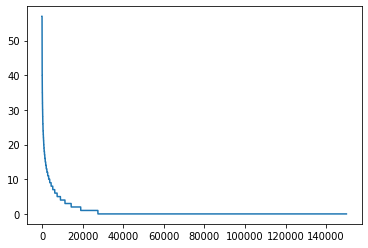

In [87]:
# 문서 당 가장 많은 횟수로 출현한 word
plt.plot(sorted([np.unique(doc, return_counts=True)[1].argmax() for doc in train_text], reverse=True))
plt.show()



## Modeling

In [92]:
from keras.layers import Input, Embedding, GRU, Dense
from keras.models import Model

def seq2seq() :
    input_x_bow = Input(shape=(100,))
    embedding = Embedding(20000,120)
    x = embedding(input_x_bow)
    z = GRU(64)(x)

    y = Dense(2, activation = 'softmax')(z)

    model = Model(input_x_bow, y)
    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'adam',
        metrics= ['accuracy']
    )
    return model

In [94]:
model = seq2seq()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 120)          2400000   
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                35712     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 2,435,842
Trainable params: 2,435,842
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(train_cut_bow_text2, train_onehot_centiment,
                 validation_data = (test_cut_bow_text2, test_onehot_centiment),
                 epochs = 2,
                 verbose = 1)

## Import the Library & Load the data

## Import the Library & Load the data

## Import the Library & Load the data

## Import the Library & Load the data